In [10]:
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shelve

x_size, y_size = 85, 15
# data.keys()  # dict_keys(['ligand_len', 'pi', 'd', 'mean', 'sigma', 'vdw_pair', 'hbond_pair'])
pdbs = ['2qbr']
root = '/opt/home/revoli/eva/Interformer/dock_results/energy_timetest/gaussian_predict'

['0']
19 142
inter_type:HBond, pi:[0.3981 0.0025 0.     0.5994], mean:[-0.1547  0.3284 -0.2437 -0.6064], y_shape:(5000,)
19 227
inter_type:OtherHBondPair, pi:[0.6748 0.3047 0.     0.0205], mean:[3.629 3.895 3.092 2.924], y_shape:(5000,)
25 185
inter_type:Hydro, pi:[0.601  0.0981 0.3009 0.    ], mean:[ 1.136   2.658   0.3245 -0.4697], y_shape:(5000,)
25 216
inter_type:OtherHydroPair, pi:[0.363  0.6286 0.0083 0.    ], mean:[3.688 3.906 2.99  2.627], y_shape:(5000,)
27 250
inter_type:OtherPair, pi:[0.5697 0.4303 0.     0.    ], mean:[3.264 3.77  2.578 2.291], y_shape:(5000,)


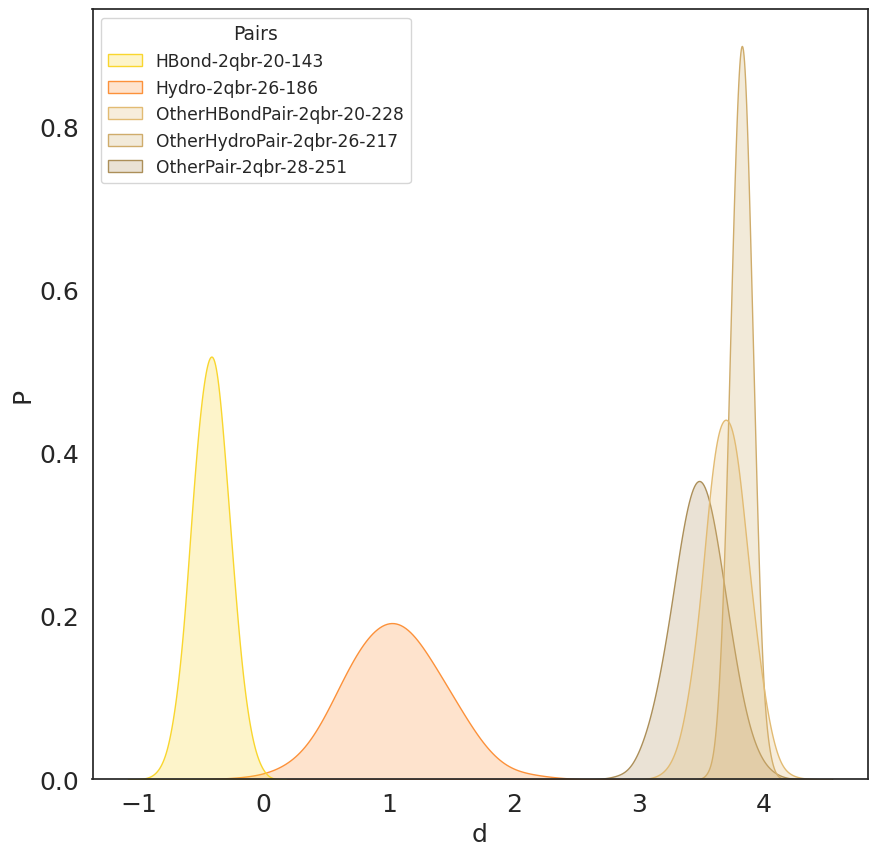

In [16]:
def gaussin(mu, sigma, bins):
    return 1. / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (bins - mu) ** 2 / (2 * sigma ** 2))


def calc_c(inter_type, mean, sigma, pi):
    dists = []
    for i in range(4):
        # i = 3
        dist = np.random.normal(loc=mean[i], scale=sigma[i], size=5000)
        dist = dist * pi[i]
        dists.append(dist[None, :])
    dists = np.concatenate(dists, axis=0)
    y = np.sum(dists, 0)
    print(f'inter_type:{inter_type}, pi:{np.round(pi, 4)}, mean:{mean}, y_shape:{y.shape}')
    return y


# get data
all_data = []
for pdb in pdbs:
    abspath_pkl_normalscore = f'{root}/{pdb}_G.db'
    with shelve.open(abspath_pkl_normalscore) as db:
        print(list(db.keys()))
        data = db['0']
    ln = int(data['ligand_len'][0])
    inter_mask = (slice(0, ln), slice(ln, None))
    d = data['d'][inter_mask]
    hbond_pair = data['hbond_pair'][inter_mask]
    hydro_pair = data['hydro_pair'][inter_mask]
    pi = data['pi'][inter_mask]
    mean = data['mean'][inter_mask]
    sigma = data['sigma'][inter_mask]
    # get gt-hbond
    hbond_i = []
    I, J, _ = np.where(d < -0.1)
    I, J = [19, 19, 25, 25, 27], [142, 227, 185, 216, 250]  # j = index-ln=28-1
    for i, j in zip(I, J):
        print(i, j)
        # type
        # if hbond_pair[i,j]:
        #     inter_type = 'hbond'
        # elif hydro_pair[i,j]:
        #     inter_type = 'hydro'
        # else:
        #     inter_type = 'other'
        if i == 19 and j == 142:
            inter_type = 'HBond'
        elif i == 19 and j == 227:
            inter_type = 'OtherHBondPair'
        elif i == 25 and j == 185:
            inter_type = 'Hydro'
        elif i == 25 and j == 216:
            inter_type = 'OtherHydroPair'
        elif i == 27 and j == 250:
            inter_type = 'OtherPair'
        #
        real_j = ln + j
        ij_name = f'{inter_type}-{pdb}-{i + 1}-{j + 1}'
        y = calc_c(inter_type, mean[i, j], sigma[i, j], pi[i, j])
        for y_index, y_i in enumerate(y):
            all_data.append([ij_name, pdb, y_i])

# Draw
fig = plt.figure(figsize=(10, 10))
columns = ['Pairs', 'pdb', 'd']
df = pd.DataFrame(all_data, columns=columns)
sns.set_style("white")
sns.set_context("notebook", font_scale=1.12)
colors = ['#f9d62e', '#fc913a', '#e2bb73', '#cfac6b', '#ac8f59']
df = df.sort_values('Pairs')
g = sns.kdeplot(data=df, x='d', hue='Pairs', fill=True, bw_adjust=2., palette=colors)  #, clip_on=False)

sns.move_legend(g, "upper left")

plt.ylabel('P', fontsize=18)
plt.xlabel('d', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fig.savefig('figures/3d.svg')
plt.show()

dict_keys(['ligand_len', 'pocket_len', 'pi', 'mean', 'sigma', 'hbond_pair', 'hydro_pair', 'd', 'vdw_pair'])
ligand_len:28, pocket_len:280
real hydro 25 57
real hydro 25 65
real hydro 25 66
real hydro 25 67
real hydro 25 184
real hydro 25 186
real hydro 25 232


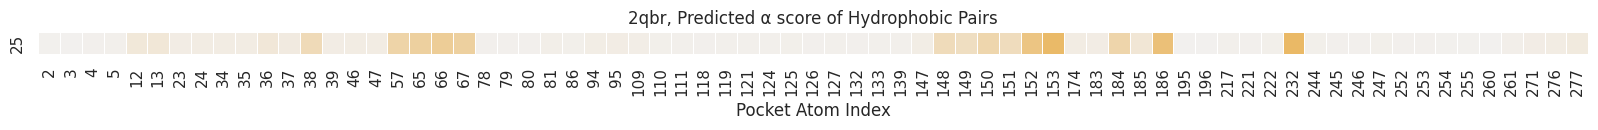

In [33]:
import pandas as pd

target_ligand_atom_idx = 24  # 19=hbond, 24=hydro


def draw_heat(df, type_name):
    # data frame
    df = df.pivot(index="x", columns="pocket", values="pi")
    df.index.name = 'Ligand Atom Index'
    df.columns.name = 'Pocket Atom Index'
    ###
    # color
    if type_name == 'hbond':
        color = sns.light_palette('#FEED62', reverse=False, as_cmap=True)  # hbond
    else:
        color = sns.light_palette('#EAB966', reverse=False, as_cmap=True)  # hydro

    # draw
    fig, ax = plt.subplots(figsize=(20, 3))
    sns.set(font_scale=1.)
    ax = sns.heatmap(df, cmap=color, ax=ax, linewidths=.5, square=True,
                     cbar=False)  # mako=hbond, flare=hydro  # , annot=True, fmt='.1f'
    ####
    ax.set_facecolor('black')
    ax.set_ylabel('')
    if type_name == 'hbond':
        ax.set_title(f'{pdb}, Predicted α score of Hydrogen Bonds Pairs')
    else:
        ax.set_title(f'{pdb}, Predicted α score of Hydrophobic Pairs')
    plt.show()


for pdb in pdbs:
    # read data
    abspath_pkl_normalscore = f'{root}/{pdb}_G.db'
    with shelve.open(abspath_pkl_normalscore) as db:
        data = db['0']
    print(data.keys())
    ln = int(data['ligand_len'][0])
    pocket_len = int(data['pocket_len'][0])
    inter_mask = (slice(0, ln), slice(ln, None))
    d = data['d'][inter_mask]
    hbond_pair = data['hbond_pair'][inter_mask]
    hydro_pair = data['hydro_pair'][inter_mask]
    pi = data['pi'][inter_mask]
    # select hBond-ligand
    I, J, _ = np.where((hbond_pair == 1) | (hydro_pair == 1))
    all_data = []
    print(f"ligand_len:{ln}, pocket_len:{pocket_len}")
    IsHBond = False
    for i, j in zip(I, J):
        name_i, name_j = i + 1, j + 1
        if i == target_ligand_atom_idx:
            if hbond_pair[i, j]:
                all_data.append([name_i, name_j, pi[i, j, -1], 'hbond'])
                if d[i, j] < 0.:
                    print('real hbond', name_i, name_j)
                    IsHBond = True
            if hydro_pair[i, j]:
                all_data.append([name_i, name_j, pi[i, j, 2], 'hydro'])
                if d[i, j] < 2.:
                    print('real hydro', name_i, name_j)
                    # magically increase the color of it
                    all_data[-1][2] += 0.15

    ###
    df = pd.DataFrame(all_data, columns=['x', 'pocket', 'pi', 'type'])
    draw_heat(df, type_name='hbond' if IsHBond else 'hydro')
    # break
# df

In [4]:
# hbond_pair = np.squeeze(data['hbond_pair'][inter_mask], -1)
# sns.set(rc={'figure.figsize':(15, 15)}, font_scale=1)
# color = sns.light_palette('#FEED62', reverse=False, as_cmap=True)
# ax = sns.heatmap(hbond_pair, cmap=color)  # mako=hbond, flare=hydro
# 
# np.where(hbond_pair[19])
# print(hbond_pair.shape)
# a = slice(0, 28)
# b = slice(28, None)
# np.allclose(data['hbond_pair'][:28, 28:], data['hbond_pair'][a, b]) 